In [1]:
# import all modules
import numpy as np
import PIL.Image as Image
import libtiff
import matplotlib
from matplotlib import pyplot as plt
import matplotlib
from skimage import io
from PRIS import * 
#import SingleObs
#from PRIS import PyPRIS
#from PRIS import L
import copy
import drawnow

%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

# Construct obseration operator

In [3]:
# construct observation operator.
 # load psf matrix
dpath = './test_data/psf.tif';
psf = io.imread(dpath)


# Load observation

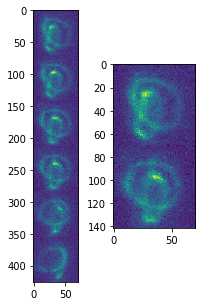

In [4]:
# load observation
data_path = './test_data';
f = 'obsStack.tif';
fov = io.imread(data_path + '/' + f)
fov.shape
plt.figure(figsize=(5,5));
plt.subplot(131)
plt.imshow(fov[[1,3,5,6,10,15],:,:].reshape(6*fov.shape[1],fov.shape[2]))
blur1 = fov[1,:,:];
blur2 = fov[7,:,:];
#100 nm step interval so there is a 600 nm separation. 24 layer separation between psf steps.

blur = np.concatenate([blur1, blur2]).reshape(2*71,71);
plt.subplot(132)
plt.imshow(blur)

# Decide candidates

In [5]:
# decide candidates 
range_ind0 = np.arange(-38,33)
range_ind1 = np.arange(5,66,4)
range_ind2 = np.arange(5,66,4)
candidate_locs = list()
for i0 in range_ind0:
    for i1 in range_ind1:
        for i2 in range_ind2:
            candidate_locs.append([i0,i1,i2])

# Construct sensing matrix

In [6]:
# construct sensing matrix
    # dependencies: candidates, observation operator.
    # yield: sensing matrix
    # method: loop over all candidates and record the corresponding observations.
a = SingleObs()
a.psf = np.copy(psf)
a.psfz0 = 106
a.debug = False
a.imsize = blur1.shape
a.edge_padding = True
A = np.ndarray([blur.shape[0]*blur.shape[1], len(candidate_locs)+1])
A.shape
for count, loc in enumerate(candidate_locs):
#for count, loc in enumerate([[0,10,10],[10,10,10]]):
    loc1 = np.copy(loc); loc1[0] = np.copy(loc[0])-12
    loc2 = np.copy(loc); loc2[0] = np.copy(loc[0])+12
    a.location = loc1
    a.single_obs()
    a1 = a.obs.ravel()
    
    a.location = loc2
    a.single_obs()
    a2 = a.obs.ravel()
    
    A[:,count] = np.concatenate([a1.ravel(),a2.ravel()]).ravel()
A[:,len(candidate_locs)] = 1

# Recovery

In [7]:
%reload_ext autoreload

In [8]:
# recover
    # input sensint matrix, and observation; 
    # yield: recovered vector
    # use scikit learn lasso solver
import time
A[:,len(candidate_locs)] = 580
Anorm = A/500
a = LinBreg(Anorm,np.zeros(A.shape[1]),blur.ravel())
a.debug = False
a.deep_debug = False
a.mu = 1000000000
a.obs_dim0 = blur.shape[0]
a.obs_dim1 = blur.shape[1]

#a.stepsize = 1e-6
a.alpha = 1e-8
a.maxit = 12010 # maximum iteration steps.
a.debug_it_int = 100
a.it_check_rem = 1
a.kick.ints = 10
a.kick.flag = True
a.kick.thres = 1e-3
a.range_ind0 = range_ind0
a.range_ind1 = range_ind1
a.range_ind2 = range_ind2
a.save_obj_int = 2000
a.save = False

a.getready()
a.go()

G:\DH_localization\PyPRIS\PyPRIS_notebooks\PRIS.py:439: RuntimeWarning: divide by zero encountered in double_scalars
  self.hist_resDrop.append((self.hist_res[it_count] - self.hist_res[it_count-1])/self.hist_res[it_count-1])


C:\Users\xiyu\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


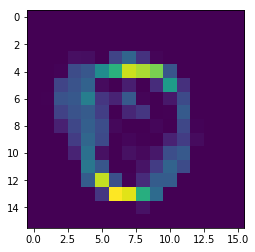

In [9]:
# related to temp visualiztion in debug-output
intervals = list([1, 4, 4])
locs = list(zip(*candidate_locs))

# related to temp visualiztion in debug-output
dims = list()
minimals = list()
maximums = list()

for inds, interval in zip(locs, intervals):
    maximum = np.max(inds)
    minimal = np.min(inds)
    dims.append(1+np.int((maximum-minimal)//interval))
    minimals.append(minimal)
    maximums.append(maximum)

# related to temp visualiztion in debug-output
temp = np.zeros(dims)
for coords, intensity in zip(candidate_locs, a.x[0:len(a.x)-1]):
    temp[coords[0]-minimals[0]-1, (coords[1]-minimals[1])/intervals[1], (coords[2]-minimals[2])/intervals[2]] = intensity
    
plt.imshow(np.mean(temp, axis = 0))

# PRIS refinement 
   ## refine coordinates of candidates

# refine coordinates
non_zero_inds = np.argwhere(a.x[0:len(a.x)-1]>0)
non_zero_coordinates = [candidate_locs[i] for i in list(non_zero_inds.ravel())]
non_zero_inds.size

previous_interval = 4
current_interval = previous_interval/2

new_coords = list()
for i in non_zero_coordinates:    
    extra_coords=[[i[0], i[1] - current_interval/2*3, i[2] - current_interval/2*3],\
                  [i[0], i[1] - current_interval/2*3, i[2] - current_interval/2  ],\
                  [i[0], i[1] - current_interval/2*3, i[2] + current_interval/2  ],\
                  [i[0], i[1] - current_interval/2*3, i[2] + current_interval/2*3],\
                  [i[0], i[1] - current_interval/2,   i[2] - current_interval/2*3],\
                  [i[0], i[1] - current_interval/2,   i[2] - current_interval/2  ],\
                  [i[0], i[1] - current_interval/2,   i[2] + current_interval/2  ],\
                  [i[0], i[1] - current_interval/2,   i[2] + current_interval/2*3],\
                  [i[0], i[1] + current_interval/2*3, i[2] - current_interval/2*3],\
                  [i[0], i[1] + current_interval/2*3, i[2] - current_interval/2  ],\
                  [i[0], i[1] + current_interval/2*3, i[2] + current_interval/2  ],\
                  [i[0], i[1] + current_interval/2*3, i[2] + current_interval/2*3],\
                  [i[0], i[1] + current_interval/2,   i[2] - current_interval/2*3],\
                  [i[0], i[1] + current_interval/2,   i[2] - current_interval/2  ],\
                  [i[0], i[1] + current_interval/2,   i[2] + current_interval/2  ],\
                  [i[0], i[1] + current_interval/2,   i[2] + current_interval/2*3]] # bisection only in x-dimesnion and y-dimension. no bisection in z.
    
    for i1 in extra_coords:
        if i1 not in new_coords:
            new_coords.append(i1)

In [10]:
# refine coordinates
non_zero_inds = np.argwhere(a.x[0:len(a.x)-1]>0)
non_zero_coordinates = [candidate_locs[i] for i in list(non_zero_inds.ravel())]
non_zero_inds.size

previous_interval = 4
current_interval = previous_interval/2

new_coords = list()
for i in non_zero_coordinates:    
    extra_coords=[[i[0], i[1] - current_interval/2,   i[2] - current_interval/2  ],\
                  [i[0], i[1] - current_interval/2,   i[2] + current_interval/2  ],\
                  [i[0], i[1] + current_interval/2,   i[2] - current_interval/2  ],\
                  [i[0], i[1] + current_interval/2,   i[2] + current_interval/2  ]] # bisection only in x-dimesnion and y-dimension. no bisection in z.
    
    for i1 in extra_coords:
        if i1 not in new_coords:
            new_coords.append(i1)

In [11]:
candidate_locs = copy.deepcopy(new_coords)

In [12]:
candidate_locs

[[-36, 20.0, 40.0],
 [-36, 20.0, 42.0],
 [-36, 22.0, 40.0],
 [-36, 22.0, 42.0],
 [-36, 20.0, 44.0],
 [-36, 20.0, 46.0],
 [-36, 22.0, 44.0],
 [-36, 22.0, 46.0],
 [-36, 24.0, 20.0],
 [-36, 24.0, 22.0],
 [-36, 26.0, 20.0],
 [-36, 26.0, 22.0],
 [-36, 24.0, 24.0],
 [-36, 24.0, 26.0],
 [-36, 26.0, 24.0],
 [-36, 26.0, 26.0],
 [-36, 24.0, 40.0],
 [-36, 24.0, 42.0],
 [-36, 26.0, 40.0],
 [-36, 26.0, 42.0],
 [-36, 24.0, 44.0],
 [-36, 24.0, 46.0],
 [-36, 26.0, 44.0],
 [-36, 26.0, 46.0],
 [-36, 24.0, 48.0],
 [-36, 24.0, 50.0],
 [-36, 26.0, 48.0],
 [-36, 26.0, 50.0],
 [-36, 28.0, 20.0],
 [-36, 28.0, 22.0],
 [-36, 30.0, 20.0],
 [-36, 30.0, 22.0],
 [-36, 28.0, 24.0],
 [-36, 28.0, 26.0],
 [-36, 30.0, 24.0],
 [-36, 30.0, 26.0],
 [-36, 28.0, 28.0],
 [-36, 28.0, 30.0],
 [-36, 30.0, 28.0],
 [-36, 30.0, 30.0],
 [-36, 28.0, 32.0],
 [-36, 28.0, 34.0],
 [-36, 30.0, 32.0],
 [-36, 30.0, 34.0],
 [-36, 28.0, 36.0],
 [-36, 28.0, 38.0],
 [-36, 30.0, 36.0],
 [-36, 30.0, 38.0],
 [-36, 28.0, 44.0],
 [-36, 28.0, 46.0],


## construct 2nd sensing matrix

In [13]:
# construct sensing matrix
    # dependencies: candidates, observation operator.
    # yield: sensing matrix
    # method: loop over all candidates and record the corresponding observations.
a = SingleObs()
a.psf = np.copy(psf)
a.psfz0 = 106
a.debug = False
a.imsize = blur1.shape
a.edge_padding = True
A = np.ndarray([blur.shape[0]*blur.shape[1], len(candidate_locs)+1])
A.shape
for count, loc in enumerate(candidate_locs):
#for count, loc in enumerate([[0,10,10],[10,10,10]]):
    loc1 = np.copy(loc); loc1[0] = np.copy(loc[0])-12
    loc2 = np.copy(loc); loc2[0] = np.copy(loc[0])+12
    a.location = loc1
    a.single_obs()
    a1 = a.obs.ravel()
    
    a.location = loc2
    a.single_obs()
    a2 = a.obs.ravel()
    
    A[:,count] = np.concatenate([a1.ravel(),a2.ravel()]).ravel()
A[:,len(candidate_locs)] = 1

In [14]:
# recover
    # input sensint matrix, and observation; 
    # yield: recovered vector
    # use scikit learn lasso solver
import time
A[:,len(candidate_locs)] = 580
Anorm = A/500
a = LinBreg(Anorm,np.zeros(A.shape[1]),blur.ravel())
a.debug = False
a.deep_debug = False
a.mu = 1000000000
a.obs_dim0 = blur.shape[0]
a.obs_dim1 = blur.shape[1]

#a.stepsize = 1e-6
a.alpha = 1e-8
a.maxit = 12010 # maximum iteration steps.
a.debug_it_int = 100
a.it_check_rem = 1
a.kick.ints = 10
a.kick.flag = True
a.kick.thres = 1e-3
a.range_ind0 = range_ind0
a.range_ind1 = range_ind1
a.range_ind2 = range_ind2
a.save_obj_int = 2000
a.save = False

a.getready()
a.go()

G:\DH_localization\PyPRIS\PyPRIS_notebooks\PRIS.py:439: RuntimeWarning: divide by zero encountered in double_scalars
  self.hist_resDrop.append((self.hist_res[it_count] - self.hist_res[it_count-1])/self.hist_res[it_count-1])


C:\Users\xiyu\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


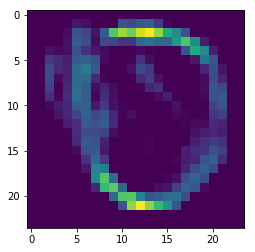

In [15]:
# related to temp visualiztion in debug-output
intervals = list([1, 2, 2])
locs = list(zip(*candidate_locs))

# related to temp visualiztion in debug-output
dims = list()
minimals = list()
maximums = list()

for inds, interval in zip(locs, intervals):
    maximum = np.max(inds)
    minimal = np.min(inds)
    dims.append(1+np.int((maximum-minimal)//interval))
    minimals.append(minimal)
    maximums.append(maximum)

# related to temp visualiztion in debug-output
temp = np.zeros(dims)
for coords, intensity in zip(candidate_locs, a.x[0:len(a.x)-1]):
    temp[coords[0]-minimals[0]-1, (coords[1]-minimals[1])/intervals[1], (coords[2]-minimals[2])/intervals[2]] = intensity
    
plt.imshow(np.mean(temp, axis = 0))

# Second refinement

In [16]:
# decide candidates 
non_zero_inds = np.argwhere(a.x[0:len(a.x)-1]>0)
non_zero_coordinates = [candidate_locs[i] for i in list(non_zero_inds.ravel())]
non_zero_inds.size

previous_interval = 2
current_interval = previous_interval/2

new_coords = list()
for i in non_zero_coordinates:    
    extra_coords=[[i[0], i[1] - current_interval/2,   i[2] - current_interval/2  ],\
                  [i[0], i[1] - current_interval/2,   i[2] + current_interval/2  ],\
                  [i[0], i[1] + current_interval/2,   i[2] - current_interval/2  ],\
                  [i[0], i[1] + current_interval/2,   i[2] + current_interval/2  ]] # bisection only in x-dimesnion and y-dimension. no bisection in z.
    
    for i1 in extra_coords:
        if i1 not in new_coords:
            new_coords.append(i1)

In [17]:
candidate_locs = copy.deepcopy(new_coords)

In [18]:
# construct sensing matrix
    # dependencies: candidates, observation operator.
    # yield: sensing matrix
    # method: loop over all candidates and record the corresponding observations.
a = SingleObs()
a.psf = np.copy(psf)
a.psfz0 = 106
a.debug = False
a.imsize = blur1.shape
a.edge_padding = True
a.subpixel_shift = True
A = np.ndarray([blur.shape[0]*blur.shape[1], len(candidate_locs)+1])
A.shape
for count, loc in enumerate(candidate_locs):
#for count, loc in enumerate([[0,10,10],[10,10,10]]):
    loc1 = np.copy(loc); loc1[0] = np.copy(loc[0])-12
    loc2 = np.copy(loc); loc2[0] = np.copy(loc[0])+12
    a.location = loc1
    a.single_obs()
    a1 = a.obs.ravel()
    
    a.location = loc2
    a.single_obs()
    a2 = a.obs.ravel()
    
    A[:,count] = np.concatenate([a1.ravel(),a2.ravel()]).ravel()
A[:,len(candidate_locs)] = 1

In [19]:
# recover
    # input sensint matrix, and observation; 
    # yield: recovered vector
    # use scikit learn lasso solver
import time
A[:,len(candidate_locs)] = 580
Anorm = A/500
a = LinBreg(Anorm,np.zeros(A.shape[1]),blur.ravel())
a.debug = False
a.deep_debug = False
a.mu = 1000000000
a.obs_dim0 = blur.shape[0]
a.obs_dim1 = blur.shape[1]

#a.stepsize = 1e-6
a.alpha = 1e-8
a.maxit = 12010 # maximum iteration steps.
a.debug_it_int = 100
a.it_check_rem = 1
a.kick.ints = 10
a.kick.flag = True
a.kick.thres = 1e-3
a.range_ind0 = range_ind0
a.range_ind1 = range_ind1
a.range_ind2 = range_ind2
a.save_obj_int = 2000
a.save = False

a.getready()
a.go()

G:\DH_localization\PyPRIS\PyPRIS_notebooks\PRIS.py:439: RuntimeWarning: divide by zero encountered in double_scalars
  self.hist_resDrop.append((self.hist_res[it_count] - self.hist_res[it_count-1])/self.hist_res[it_count-1])


In [20]:
# related to temp visualiztion in debug-output
intervals = list([1, 1, 1])
locs = list(zip(*candidate_locs))

# related to temp visualiztion in debug-output
dims = list()
minimals = list()
maximums = list()

for inds, interval in zip(locs, intervals):
    maximum = np.max(inds)
    minimal = np.min(inds)
    dims.append(1+np.int((maximum-minimal)//interval))
    minimals.append(minimal)
    maximums.append(maximum)

# related to temp visualiztion in debug-output
temp = np.zeros(dims)
for coords, intensity in zip(candidate_locs, a.x[0:len(a.x)-1]):
    temp[coords[0]-minimals[0]-1, (coords[1]-minimals[1])/intervals[1], (coords[2]-minimals[2])/intervals[2]] = intensity

C:\Users\xiyu\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


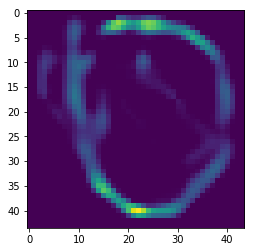

In [21]:
plt.imshow(np.mean(temp, axis = 0))

# 3rd refinement

In [22]:
# decide candidates 
non_zero_inds = np.argwhere(a.x[0:len(a.x)-1]>0)
non_zero_coordinates = [candidate_locs[i] for i in list(non_zero_inds.ravel())]
non_zero_inds.size

previous_interval = 1
current_interval = previous_interval/2

new_coords = list()
for i in non_zero_coordinates:    
    extra_coords=[[i[0], i[1] - current_interval/2,   i[2] - current_interval/2  ],\
                  [i[0], i[1] - current_interval/2,   i[2] + current_interval/2  ],\
                  [i[0], i[1] + current_interval/2,   i[2] - current_interval/2  ],\
                  [i[0], i[1] + current_interval/2,   i[2] + current_interval/2  ]] # bisection only in x-dimesnion and y-dimension. no bisection in z.
    
    for i1 in extra_coords:
        if i1 not in new_coords:
            new_coords.append(i1)

In [23]:
candidate_locs = copy.deepcopy(new_coords)

In [24]:
# construct sensing matrix
    # dependencies: candidates, observation operator.
    # yield: sensing matrix
    # method: loop over all candidates and record the corresponding observations.
a = SingleObs()
a.psf = np.copy(psf)
a.psfz0 = 106
a.debug = False
a.imsize = blur1.shape
a.edge_padding = True
a.subpixel_shift = True
A = np.ndarray([blur.shape[0]*blur.shape[1], len(candidate_locs)+1])
A.shape
for count, loc in enumerate(candidate_locs):
#for count, loc in enumerate([[0,10,10],[10,10,10]]):
    loc1 = np.copy(loc); loc1[0] = np.copy(loc[0])-12
    loc2 = np.copy(loc); loc2[0] = np.copy(loc[0])+12
    a.location = loc1
    a.single_obs()
    a1 = a.obs.ravel()
    
    a.location = loc2
    a.single_obs()
    a2 = a.obs.ravel()
    
    A[:,count] = np.concatenate([a1.ravel(),a2.ravel()]).ravel()
    
A[:,len(candidate_locs)] = 1

In [ ]:
# recover
    # input sensint matrix, and observation; 
    # yield: recovered vector
    # use scikit learn lasso solver
import time
A[:,len(candidate_locs)] = 580
Anorm = A/500
a = LinBreg(Anorm,np.zeros(A.shape[1]),blur.ravel())
a.debug = False
a.deep_debug = False
a.mu = 1000000000
a.obs_dim0 = blur.shape[0]
a.obs_dim1 = blur.shape[1]

#a.stepsize = 1e-6
a.alpha = 1e-8
a.maxit = 12010 # maximum iteration steps.
a.debug_it_int = 100
a.it_check_rem = 1
a.kick.ints = 10
a.kick.flag = True
a.kick.thres = 1e-3
a.range_ind0 = range_ind0
a.range_ind1 = range_ind1
a.range_ind2 = range_ind2
a.save_obj_int = 2000
a.save = False

a.getready()
a.go()

G:\DH_localization\PyPRIS\PyPRIS_notebooks\PRIS.py:439: RuntimeWarning: divide by zero encountered in double_scalars
  self.hist_resDrop.append((self.hist_res[it_count] - self.hist_res[it_count-1])/self.hist_res[it_count-1])


In [ ]:
# related to temp visualiztion in debug-output
intervals = list([1, 0.5, 0.5])
locs = list(zip(*candidate_locs))

# related to temp visualiztion in debug-output
dims = list()
minimals = list()
maximums = list()

for inds, interval in zip(locs, intervals):
    maximum = np.max(inds)
    minimal = np.min(inds)
    dims.append(1+np.int((maximum-minimal)//interval))
    minimals.append(minimal)
    maximums.append(maximum)

# related to temp visualiztion in debug-output
temp = np.zeros(dims)
for coords, intensity in zip(candidate_locs, a.x[0:len(a.x)-1]):
    temp[coords[0]-minimals[0]-1, (coords[1]-minimals[1])/intervals[1], (coords[2]-minimals[2])/intervals[2]] = intensity

In [ ]:
plt.imshow(np.mean(temp, axis = 0))